In [1]:
### Load the required libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import re

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%%time
import nltk
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from sentence_transformers import SentenceTransformer, util

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91994\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Wall time: 11.3 s


In [3]:
### To read the useful csv file into DataFrame

df = pd.read_csv(r"reviews_badminton.csv")

In [4]:
df

Reviewer Name               Review Title  \
0               Kamal Suresh               Nice product   
1          Flipkart Customer     Don't waste your money   
2     A. S. Raja Srinivasan   Did not meet expectations   
3        Suresh Narayanasamy                       Fair   
4                  ASHIK P A                Over priced   
...                      ...                        ...   
8513                     NaN                        NaN   
8514                     NaN                        NaN   
8515                     NaN                        NaN   
8516                     NaN                        NaN   
8517                     NaN                        NaN   

                  Place of Review  Up Votes  Down Votes     Month  \
0      Certified Buyer, Chirakkal     889.0        64.0  Feb 2021   
1      Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
2     Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
3        Certified Buyer, Chennai      25.0         1.0       NaN   
4                             NaN     147.0        24.0  Apr 2016   
...                           ...       ...         ...       ...   
8513                          NaN       NaN         NaN       NaN   
8514                          NaN       NaN         NaN       NaN   
8515                          NaN       NaN         NaN       NaN   
8516                          NaN       NaN         NaN       NaN   
8517                          NaN       NaN         NaN       NaN   

                                            Review text  Ratings  
0     Nice product, good quality, but price is now r...        4  
1     They didn't supplied Yonex Mavis 350. Outside ...        1  
2     Worst product. Damaged shuttlecocks packed in ...        1  
3     Quite O. K. , but nowadays  the quality of the...        3  
4     Over pricedJust â?¹620 ..from retailer.I didn'...        1  
...                                                 ...      ...  
8513                                                NaN        5  
8514                                                NaN        2  
8515                                                NaN        4  
8516                                                NaN        1  
8517                                                NaN        4  

[8518 rows x 8 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [6]:
df.shape

(8518, 8)

In [7]:
df.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

In [8]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [9]:
mode_review_text = df.groupby('Ratings')['Review text'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_title = df.groupby('Ratings')['Review Title'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_up_votes = df.groupby('Ratings')['Up Votes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_down_votes = df.groupby('Ratings')['Down Votes'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_reviewer_name = df.groupby('Ratings')['Reviewer Name'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_place_of_review = df.groupby('Ratings')['Place of Review'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_review_month = df.groupby('Ratings')['Month'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

In [10]:
mode_review_text

Ratings                   Review text
0        1             Not goodREAD MORE
1        2  Quality is not goodREAD MORE
2        3                 GoodREAD MORE
3        4                 GoodREAD MORE
4        5                 GoodREAD MORE

In [11]:
mode_review_title

Ratings               Review Title
0        1  Did not meet expectations
1        2                   Not good
2        3                  Wonderful
3        4                  Wonderful
4        5                  Wonderful

In [12]:
mode_review_up_votes

Ratings  Up Votes
0        1       0.0
1        2       0.0
2        3       0.0
3        4       0.0
4        5       0.0

In [13]:
mode_review_down_votes

Ratings  Down Votes
0        1         0.0
1        2         0.0
2        3         0.0
3        4         0.0
4        5         0.0

In [14]:
mode_reviewer_name

Ratings      Reviewer Name
0        1  Flipkart Customer
1        2  Flipkart Customer
2        3  Flipkart Customer
3        4  Flipkart Customer
4        5  Flipkart Customer

In [15]:
mode_place_of_review

Ratings             Place of Review
0        1  Certified Buyer, Bengaluru
1        2    Certified Buyer, Chennai
2        3  Certified Buyer, Bengaluru
3        4    Certified Buyer, Chennai
4        5  Certified Buyer, Bengaluru

In [16]:
mode_review_month

Ratings     Month
0        1  Dec 2018
1        2  Nov 2020
2        3  Oct 2020
3        4  Jul 2020
4        5  Oct 2020

In [17]:
dfs = [mode_reviewer_name, mode_review_title, mode_place_of_review, mode_review_up_votes, mode_review_down_votes, mode_review_month, mode_review_text]

In [18]:
from functools import reduce
new = reduce(lambda  left,right: pd.merge(left,right,on=['Ratings'], how='outer'), dfs)

In [19]:
new

Ratings      Reviewer Name               Review Title  \
0        1  Flipkart Customer  Did not meet expectations   
1        2  Flipkart Customer                   Not good   
2        3  Flipkart Customer                  Wonderful   
3        4  Flipkart Customer                  Wonderful   
4        5  Flipkart Customer                  Wonderful   

              Place of Review  Up Votes  Down Votes     Month  \
0  Certified Buyer, Bengaluru       0.0         0.0  Dec 2018   
1    Certified Buyer, Chennai       0.0         0.0  Nov 2020   
2  Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   
3    Certified Buyer, Chennai       0.0         0.0  Jul 2020   
4  Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   

                    Review text  
0             Not goodREAD MORE  
1  Quality is not goodREAD MORE  
2                 GoodREAD MORE  
3                 GoodREAD MORE  
4                 GoodREAD MORE

In [20]:
df = df.set_index('Ratings')
new = new.set_index('Ratings')

In [21]:
df1 = df.combine_first(new).reset_index()

In [22]:
df1

Ratings           Reviewer Name               Review Title  \
0           1       Flipkart Customer     Don't waste your money   
1           1  A. S. Raja Srinivasan   Did not meet expectations   
2           1               ASHIK P A                Over priced   
3           1                Hashim A  Did not meet expectations   
4           1                Harish R    I think it is duplicate   
...       ...                     ...                        ...   
8513        5             Jayachandra                  High cost   
8514        5                naresh g               For Mavis350   
8515        5            vishnu varma                Really Nice   
8516        5       Flipkart Customer                  Wonderful   
8517        5       Flipkart Customer                  Wonderful   

                  Place of Review  Up Votes  Down Votes     Month  \
0      Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
1     Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
2      Certified Buyer, Bengaluru     147.0        24.0  Apr 2016   
3         Certified Buyer, Panoor      22.0         5.0  Mar 2021   
4      Certified Buyer, Bangalore      81.0        35.0  Feb 2018   
...                           ...       ...         ...       ...   
8513   Certified Buyer, Mangalore       0.0         0.0  Dec 2015   
8514   Certified Buyer, Bengaluru       2.0         1.0  Aug 2016   
8515    Certified Buyer, Agartala       0.0         1.0  Sep 2016   
8516   Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   
8517   Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   

                                            Review text  
0     They didn't supplied Yonex Mavis 350. Outside ...  
1     Worst product. Damaged shuttlecocks packed in ...  
2     Over pricedJust â?¹620 ..from retailer.I didn'...  
3     This is the second time i am getting an opened...  
4     I usually buy them the same model but this did...  
...                                                 ...  
8513  Hii flipkart customers care..why your delivery...  
8514        Received product intact and sealedREAD MORE  
8515                       Nice delivery speedREAD MORE  
8516  No complaints about the item . Its the best on...  
8517                                      GoodREAD MORE  

[8518 rows x 8 columns]

In [23]:
df1["Combine Review"] = df1['Review Title'] +' ' + df1['Review text']

In [24]:
df1

Ratings           Reviewer Name               Review Title  \
0           1       Flipkart Customer     Don't waste your money   
1           1  A. S. Raja Srinivasan   Did not meet expectations   
2           1               ASHIK P A                Over priced   
3           1                Hashim A  Did not meet expectations   
4           1                Harish R    I think it is duplicate   
...       ...                     ...                        ...   
8513        5             Jayachandra                  High cost   
8514        5                naresh g               For Mavis350   
8515        5            vishnu varma                Really Nice   
8516        5       Flipkart Customer                  Wonderful   
8517        5       Flipkart Customer                  Wonderful   

                  Place of Review  Up Votes  Down Votes     Month  \
0      Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
1     Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
2      Certified Buyer, Bengaluru     147.0        24.0  Apr 2016   
3         Certified Buyer, Panoor      22.0         5.0  Mar 2021   
4      Certified Buyer, Bangalore      81.0        35.0  Feb 2018   
...                           ...       ...         ...       ...   
8513   Certified Buyer, Mangalore       0.0         0.0  Dec 2015   
8514   Certified Buyer, Bengaluru       2.0         1.0  Aug 2016   
8515    Certified Buyer, Agartala       0.0         1.0  Sep 2016   
8516   Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   
8517   Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   

                                            Review text  \
0     They didn't supplied Yonex Mavis 350. Outside ...   
1     Worst product. Damaged shuttlecocks packed in ...   
2     Over pricedJust â?¹620 ..from retailer.I didn'...   
3     This is the second time i am getting an opened...   
4     I usually buy them the same model but this did...   
...                                                 ...   
8513  Hii flipkart customers care..why your delivery...   
8514        Received product intact and sealedREAD MORE   
8515                       Nice delivery speedREAD MORE   
8516  No complaints about the item . Its the best on...   
8517                                      GoodREAD MORE   

                                         Combine Review  
0     Don't waste your money They didn't supplied Yo...  
1     Did not meet expectations Worst product. Damag...  
2     Over priced Over pricedJust â?¹620 ..from reta...  
3     Did not meet expectations This is the second t...  
4     I think it is duplicate I usually buy them the...  
...                                                 ...  
8513  High cost Hii flipkart customers care..why you...  
8514  For Mavis350 Received product intact and seale...  
8515           Really Nice Nice delivery speedREAD MORE  
8516  Wonderful No complaints about the item . Its t...  
8517                            Wonderful GoodREAD MORE  

[8518 rows x 9 columns]

In [25]:
# Function to classify reviews as positive or negative based on ratings
def classify_review(rating):
    if rating >= 3.0:
        return 'Positive'
    else:
        return 'Negative'
    
df1['Review Sentiment'] = df1['Ratings'].apply(classify_review)

In [26]:
df1

Ratings           Reviewer Name               Review Title  \
0           1       Flipkart Customer     Don't waste your money   
1           1  A. S. Raja Srinivasan   Did not meet expectations   
2           1               ASHIK P A                Over priced   
3           1                Hashim A  Did not meet expectations   
4           1                Harish R    I think it is duplicate   
...       ...                     ...                        ...   
8513        5             Jayachandra                  High cost   
8514        5                naresh g               For Mavis350   
8515        5            vishnu varma                Really Nice   
8516        5       Flipkart Customer                  Wonderful   
8517        5       Flipkart Customer                  Wonderful   

                  Place of Review  Up Votes  Down Votes     Month  \
0      Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
1     Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
2      Certified Buyer, Bengaluru     147.0        24.0  Apr 2016   
3         Certified Buyer, Panoor      22.0         5.0  Mar 2021   
4      Certified Buyer, Bangalore      81.0        35.0  Feb 2018   
...                           ...       ...         ...       ...   
8513   Certified Buyer, Mangalore       0.0         0.0  Dec 2015   
8514   Certified Buyer, Bengaluru       2.0         1.0  Aug 2016   
8515    Certified Buyer, Agartala       0.0         1.0  Sep 2016   
8516   Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   
8517   Certified Buyer, Bengaluru       0.0         0.0  Oct 2020   

                                            Review text  \
0     They didn't supplied Yonex Mavis 350. Outside ...   
1     Worst product. Damaged shuttlecocks packed in ...   
2     Over pricedJust â?¹620 ..from retailer.I didn'...   
3     This is the second time i am getting an opened...   
4     I usually buy them the same model but this did...   
...                                                 ...   
8513  Hii flipkart customers care..why your delivery...   
8514        Received product intact and sealedREAD MORE   
8515                       Nice delivery speedREAD MORE   
8516  No complaints about the item . Its the best on...   
8517                                      GoodREAD MORE   

                                         Combine Review Review Sentiment  
0     Don't waste your money They didn't supplied Yo...         Negative  
1     Did not meet expectations Worst product. Damag...         Negative  
2     Over priced Over pricedJust â?¹620 ..from reta...         Negative  
3     Did not meet expectations This is the second t...         Negative  
4     I think it is duplicate I usually buy them the...         Negative  
...                                                 ...              ...  
8513  High cost Hii flipkart customers care..why you...         Positive  
8514  For Mavis350 Received product intact and seale...         Positive  
8515           Really Nice Nice delivery speedREAD MORE         Positive  
8516  Wonderful No complaints about the item . Its t...         Positive  
8517                            Wonderful GoodREAD MORE         Positive  

[8518 rows x 10 columns]

In [27]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ratings           8518 non-null   int64  
 1   Reviewer Name     8518 non-null   object 
 2   Review Title      8518 non-null   object 
 3   Place of Review   8518 non-null   object 
 4   Up Votes          8518 non-null   float64
 5   Down Votes        8518 non-null   float64
 6   Month             8518 non-null   object 
 7   Review text       8518 non-null   object 
 8   Combine Review    8518 non-null   object 
 9   Review Sentiment  8518 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 665.6+ KB


In [28]:
df1.shape

(8518, 10)

In [29]:
df1['Review Sentiment'].value_counts()

Positive    7441
Negative    1077
Name: Review Sentiment, dtype: int64

In [30]:
df1['Review Sentiment'].value_counts(normalize=True)

Positive    0.873562
Negative    0.126438
Name: Review Sentiment, dtype: float64

<AxesSubplot:xlabel='Review Sentiment', ylabel='count'>

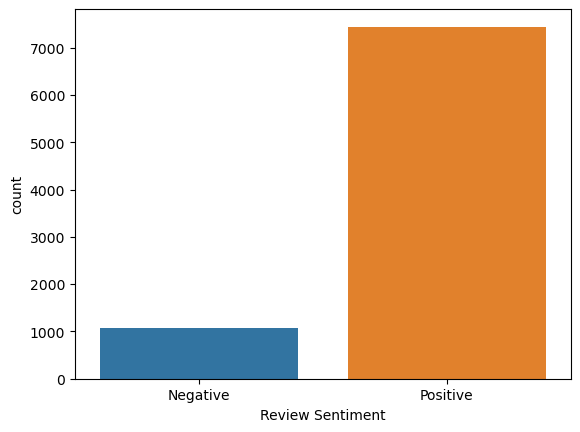

In [31]:
sns.countplot(x='Review Sentiment', data=df1)

<AxesSubplot:ylabel='Review Sentiment'>

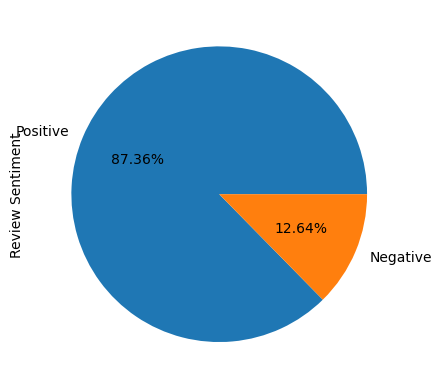

In [32]:
df1['Review Sentiment'].value_counts().plot.pie(autopct='%.2f%%')

In [33]:
df1.columns

Index(['Ratings', 'Reviewer Name', 'Review Title', 'Place of Review',
       'Up Votes', 'Down Votes', 'Month', 'Review text', 'Combine Review',
       'Review Sentiment'],
      dtype='object')

In [34]:
X = df1[['Combine Review']]
y = df1['Review Sentiment']

In [35]:
# Splitting into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train.head()

Combine Review
6289                         Really Nice superREAD MORE
549   Must buy! Very slow shuttle. Feels like cheate...
4707                    Excellent Nice productREAD MORE
764   Yones Mavis 350 Blue cap Wrost and duplicate p...
6861                          Good choice goodREAD MORE

In [37]:
X_train.shape

(6814, 1)

In [38]:
y_train.head()

6289    Positive
549     Negative
4707    Positive
764     Negative
6861    Positive
Name: Review Sentiment, dtype: object

In [39]:
tqdm.pandas()

In [40]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

In [41]:
## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()

In [42]:
def preprocess(raw_text, flag):
    # Removing special characters and digits
    sentence = re.sub(r"[^A-z0-9 ]", " ", raw_text)
    sentence = re.sub(r"_", " ", raw_text)
    
    # change sentence to lower case
    sentence = sentence.lower()

    # tokenize into words
    tokens = sentence.split()
    
    # remove stop words                
    clean_tokens = [t for t in tokens if not t in stopwords.words("english")]
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    return pd.Series([" ".join(clean_tokens)])

In [43]:
temp_df = X_train['Combine Review'].progress_apply(lambda x: preprocess(x, 'stem'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 6814/6814 [00:42<00:00, 160.92it/s]


0
6289                              realli nice superread
549   must buy! slow shuttle. feel like cheat qualit...
4707                             excel nice productread
764   yone mavi 350 blue cap wrost duplic productdon...
6861                                good choic goodread

In [44]:
temp_df.columns = ['clean_combine_review_stem']

temp_df.head()

clean_combine_review_stem
6289                              realli nice superread
549   must buy! slow shuttle. feel like cheat qualit...
4707                             excel nice productread
764   yone mavi 350 blue cap wrost duplic productdon...
6861                                good choic goodread

In [45]:
X_train = pd.concat([X_train, temp_df], axis=1)

X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  
6289                              realli nice superread  
549   must buy! slow shuttle. feel like cheat qualit...  
4707                             excel nice productread  
764   yone mavi 350 blue cap wrost duplic productdon...  
6861                                good choic goodread

In [46]:
temp_df = X_train['Combine Review'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 6814/6814 [00:42<00:00, 159.19it/s]


0
6289                              really nice superread
549   must buy! slow shuttle. feel like cheated qual...
4707                         excellent nice productread
764   yones mavis 350 blue cap wrost duplicate produ...
6861                               good choice goodread

In [47]:
temp_df.columns = ['clean_combine_review_lemma']

temp_df.head()

clean_combine_review_lemma
6289                              really nice superread
549   must buy! slow shuttle. feel like cheated qual...
4707                         excellent nice productread
764   yones mavis 350 blue cap wrost duplicate produ...
6861                               good choice goodread

In [48]:
X_train = pd.concat([X_train, temp_df], axis=1)

X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  
6289                              really nice superread  
549   must buy! slow shuttle. feel like cheated qual...  
4707                         excellent nice productread  
764   yones mavis 350 blue cap wrost duplicate produ...  
6861                               good choice goodread

In [49]:
y_train

6289    Positive
549     Negative
4707    Positive
764     Negative
6861    Positive
          ...   
5734    Positive
5191    Positive
5390    Positive
860     Negative
7270    Positive
Name: Review Sentiment, Length: 6814, dtype: object

In [50]:
Positive_df = X_train.loc[y_train=='Positive', :]

Positive_df.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
4707                    Excellent Nice productREAD MORE   
6861                          Good choice goodREAD MORE   
2304  Terrific It seems ok by looks. I would rewrite...   
5849                      Super! Best shuttlesREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
4707                             excel nice productread   
6861                                good choic goodread   
2304  terrif seem ok looks. would rewrit use whole 2...   
5849                           super! best shuttlesread   

                             clean_combine_review_lemma  
6289                              really nice superread  
4707                         excellent nice productread  
6861                               good choice goodread  
2304  terrific seems ok looks. would rewrite using w...  
5849                           super! best shuttlesread

In [51]:
words = ' '.join(Positive_df['clean_combine_review_lemma'])

print(words[:100])

really nice superread excellent nice productread good choice goodread terrific seems ok looks. would


In [52]:
Positive_df = X_train.loc[y_train=='Positive', :]

words = ' '.join(Positive_df['clean_combine_review_lemma'])

cleaned_word = " ".join([word for word in words.split() 
                        if 'subject' not in word])

In [53]:
Positive_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

<Figure size 3000x2000 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

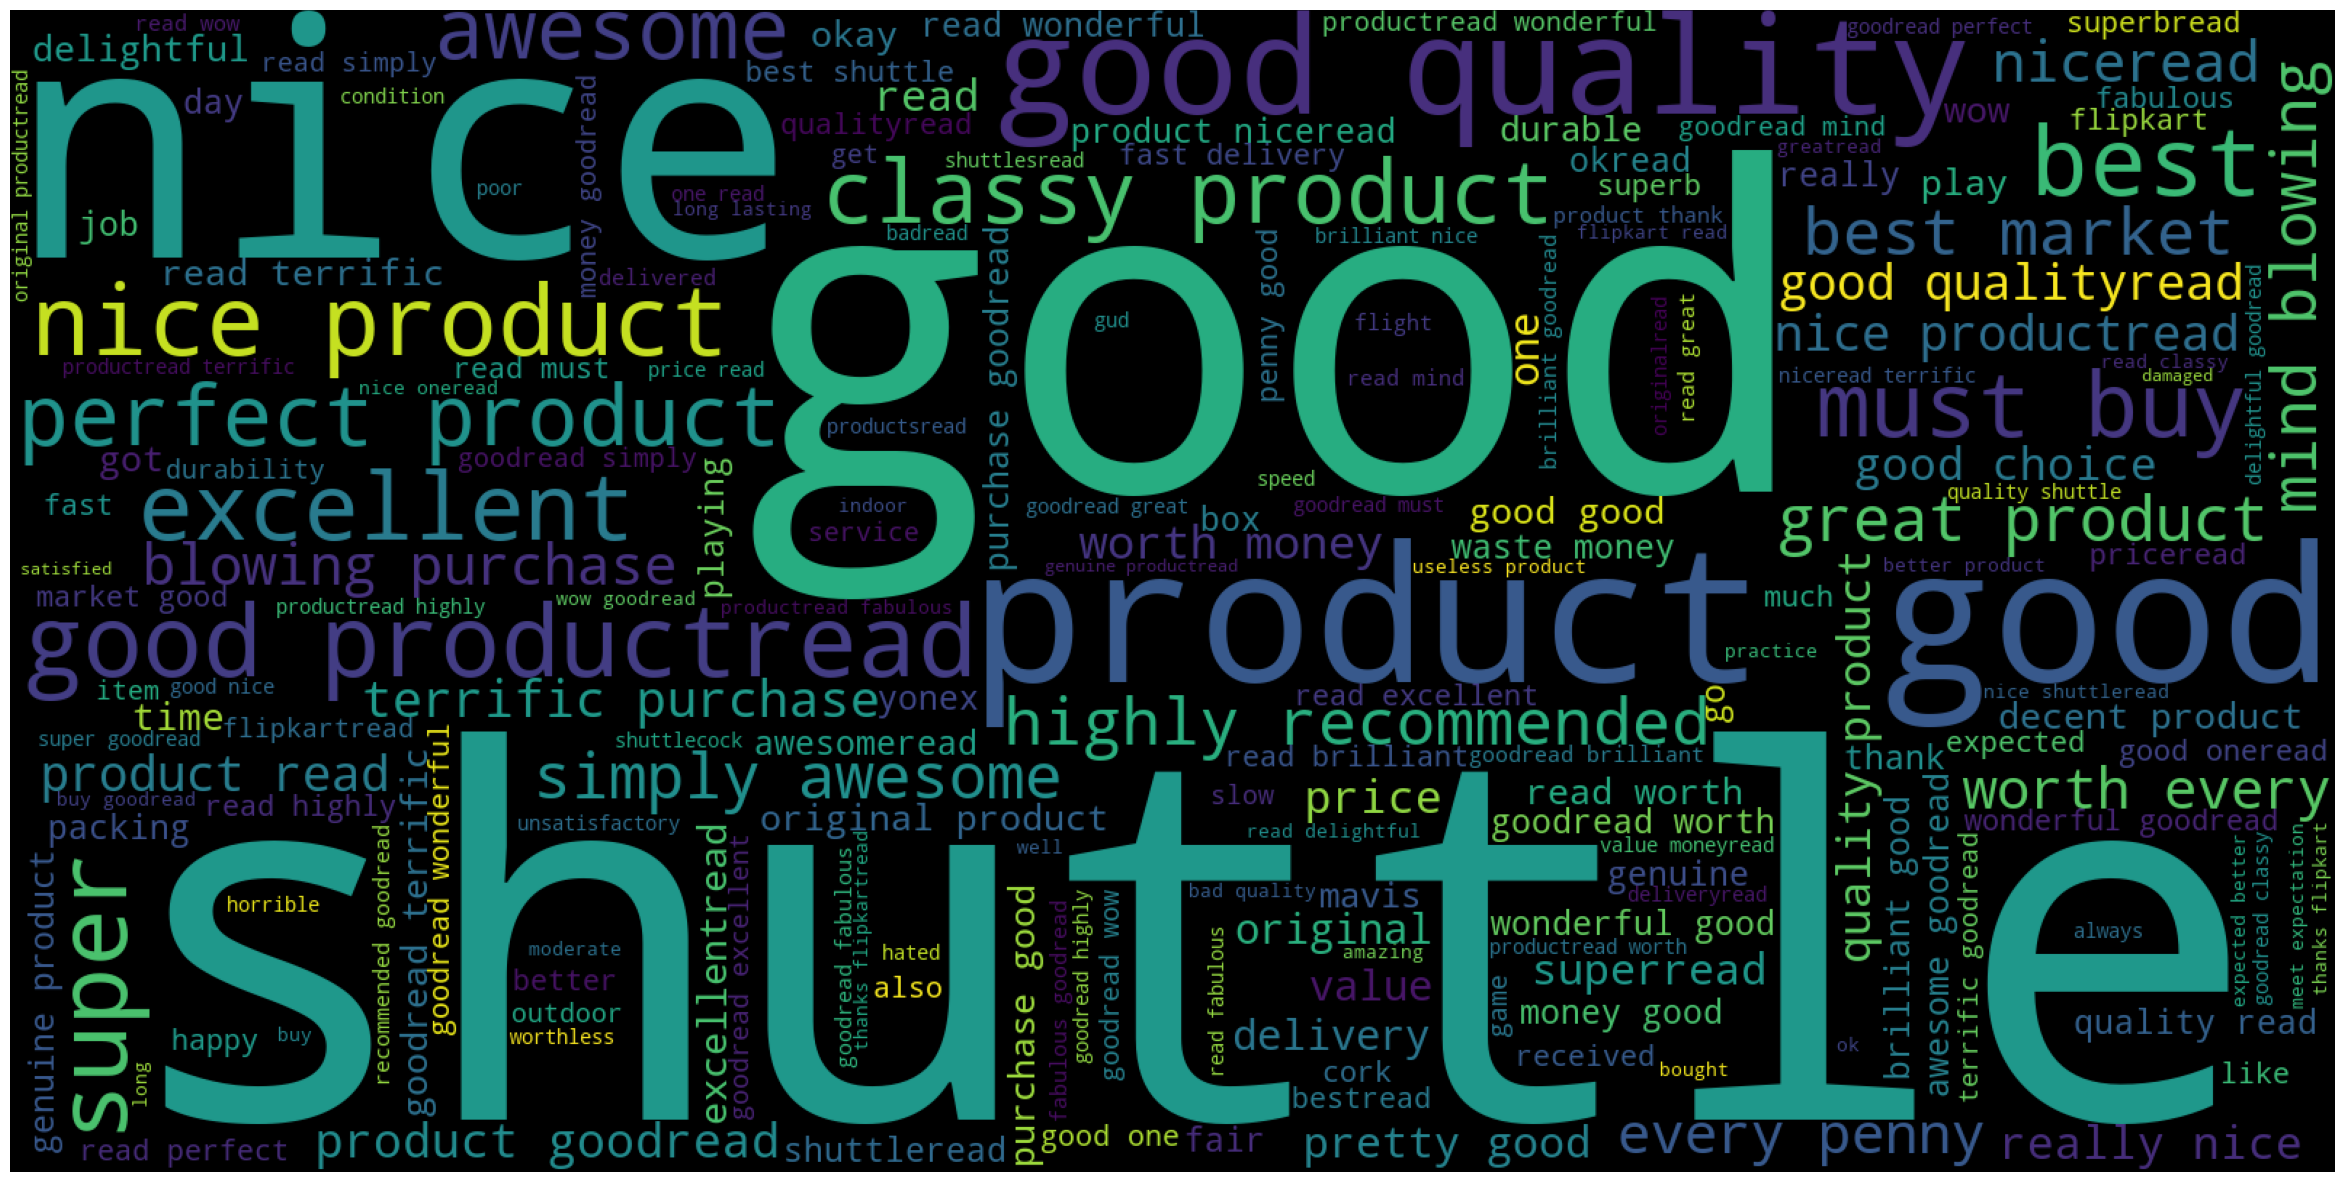

In [54]:
plt.figure(1,figsize=(30,20))
plt.imshow(Positive_wordcloud)
plt.axis('off')
plt.show()

In [55]:
Negative_df = X_train.loc[y_train=='Negative', :]

words = ' '.join(Negative_df['clean_combine_review_lemma'])

cleaned_word = " ".join([word for word in words.split() 
                        if 'subject' not in word])

In [56]:
Negative_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

<Figure size 3000x2000 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

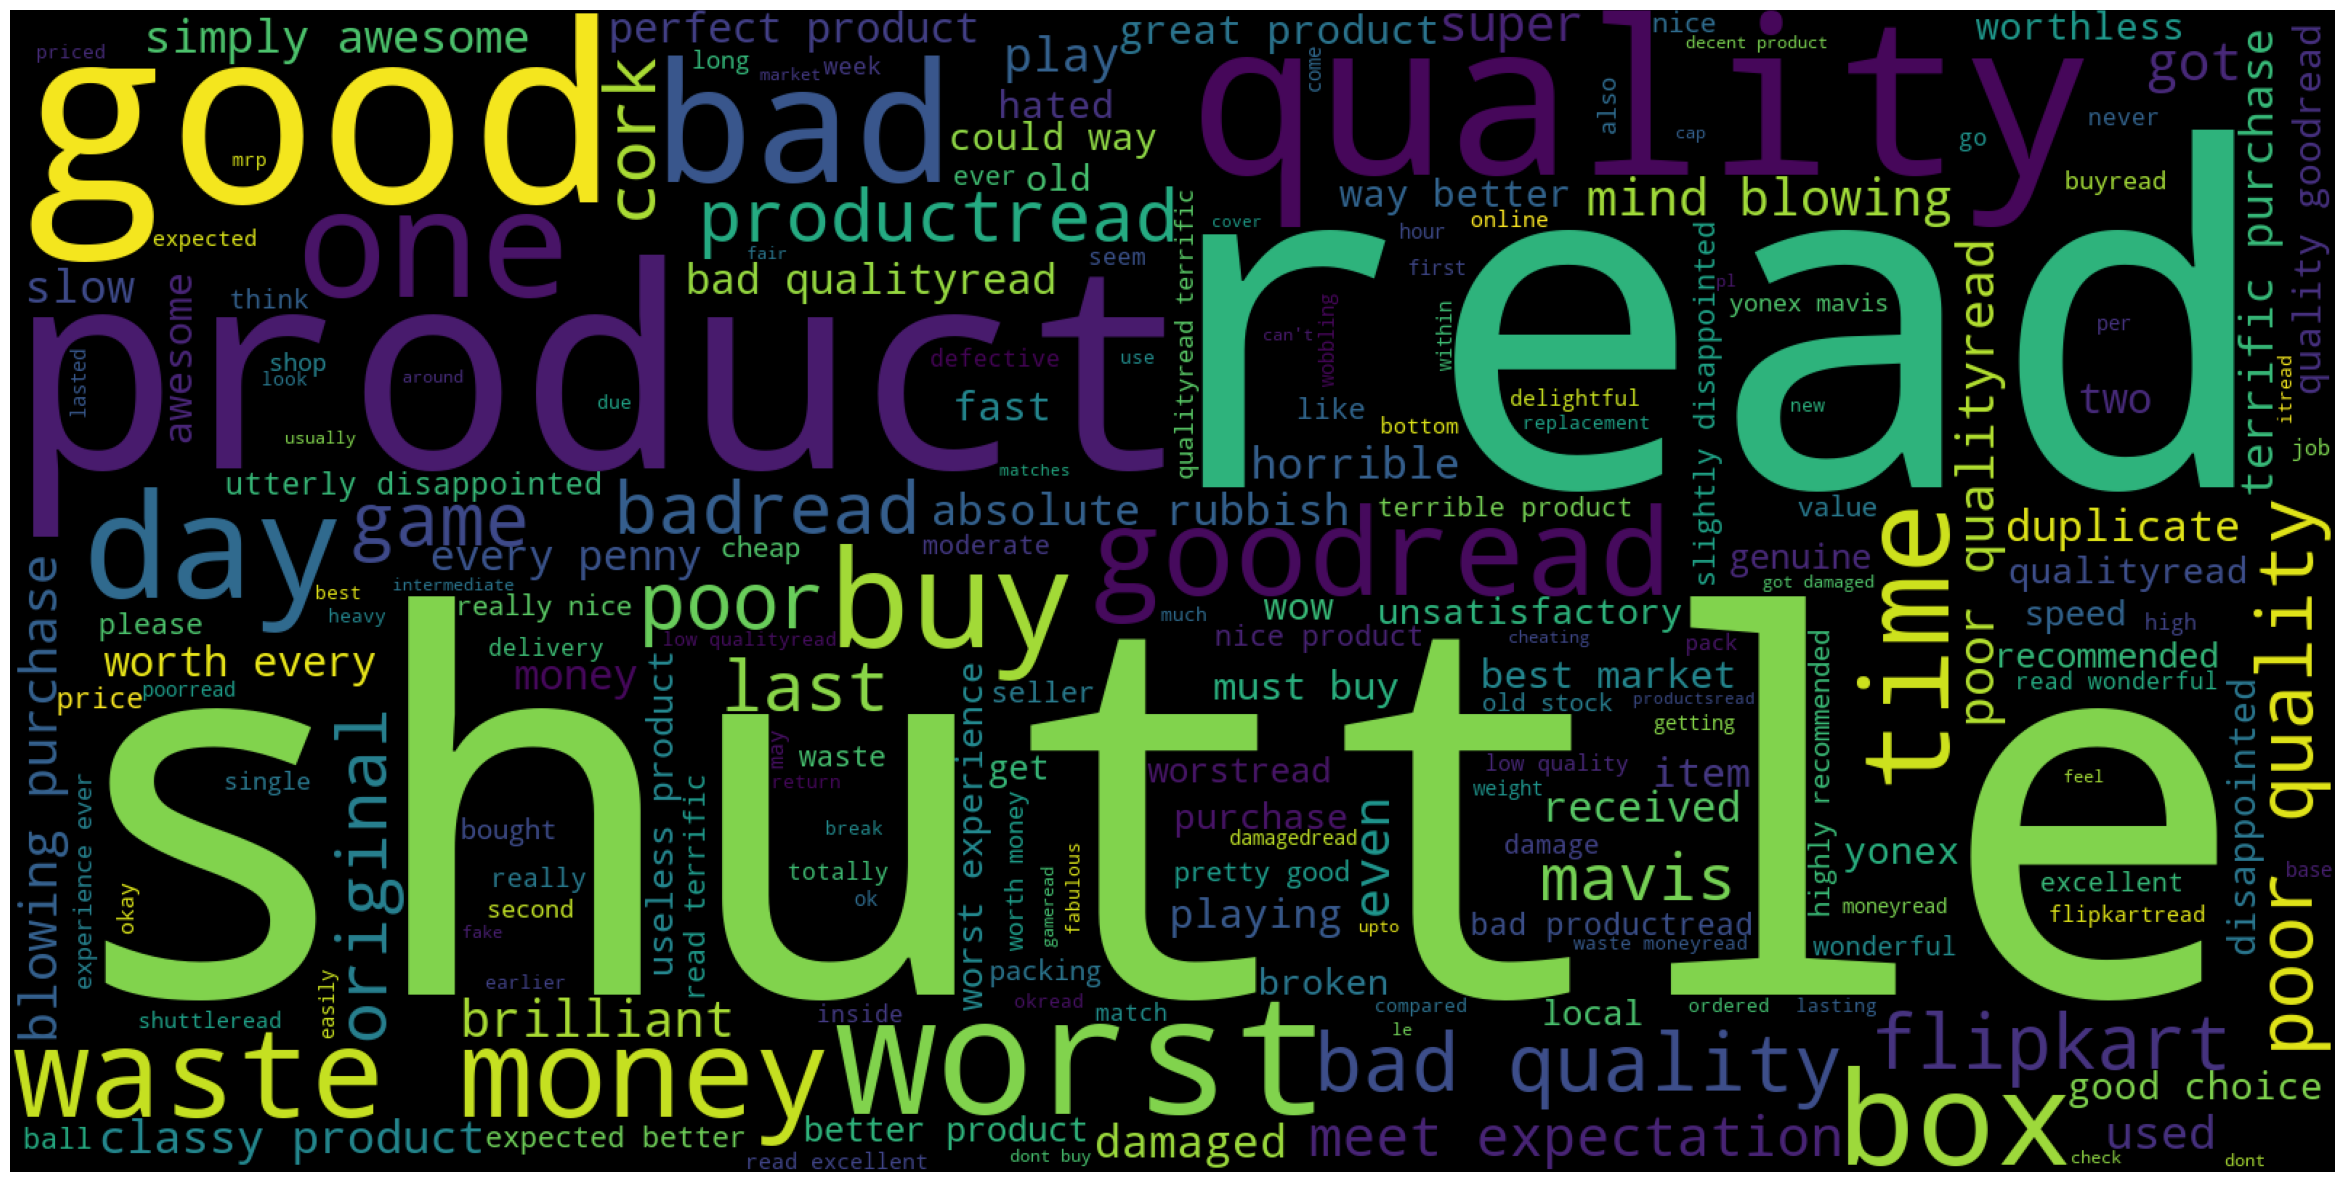

In [57]:
plt.figure(1,figsize=(30,20))
plt.imshow(Negative_wordcloud)
plt.axis('off')
plt.show()

## Converting Text to Numerical vectors - BOW Representation

In [58]:
X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  
6289                              really nice superread  
549   must buy! slow shuttle. feel like cheated qual...  
4707                         excellent nice productread  
764   yones mavis 350 blue cap wrost duplicate produ...  
6861                               good choice goodread

In [59]:
vocab = CountVectorizer()

X_train_bow = vocab.fit_transform(X_train['clean_combine_review_lemma'])

In [60]:
X_train_bow

<6814x2968 sparse matrix of type '<class 'numpy.int64'>'
	with 35705 stored elements in Compressed Sparse Row format>

In [61]:
print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words: 2968
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (6814, 2968)


In [62]:
print(X_train_bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [63]:
from sys import getsizeof

print(type(X_train_bow))
print(getsizeof(X_train_bow), "Bytes")

<class 'scipy.sparse._csr.csr_matrix'>
48 Bytes


In [64]:
from sys import getsizeof

print(type(X_train_bow.toarray()))
print(getsizeof(X_train_bow.toarray()), "Bytes")

<class 'numpy.ndarray'>
161791744 Bytes


In [65]:
X_test.head()

Combine Review
7497  Nice product Happy with this productREAD MORE
5257                 Terrible product GoodREAD MORE
2571        Terrific purchase As regular 😇READ MORE
1084                Nice One day 1cap gaanREAD MORE
856                      Very Good No goodREAD MORE

In [66]:
temp_df = X_test['Combine Review'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df.head()

100%|█████████████████████████████████████████████████████████████████████████████| 1704/1704 [00:11<00:00, 147.25it/s]


0
7497   nice product happy productread
5257        terrible product goodread
2571  terrific purchase regular 😇read
1084       nice one day 1cap gaanread
856                     good goodread

In [67]:
temp_df.columns = ['clean_combine_review_lemma']

temp_df.head()

clean_combine_review_lemma
7497   nice product happy productread
5257        terrible product goodread
2571  terrific purchase regular 😇read
1084       nice one day 1cap gaanread
856                     good goodread

In [68]:
X_test = pd.concat([X_test, temp_df], axis=1)

X_test.head()

Combine Review  \
7497  Nice product Happy with this productREAD MORE   
5257                 Terrible product GoodREAD MORE   
2571        Terrific purchase As regular 😇READ MORE   
1084                Nice One day 1cap gaanREAD MORE   
856                      Very Good No goodREAD MORE   

           clean_combine_review_lemma  
7497   nice product happy productread  
5257        terrible product goodread  
2571  terrific purchase regular 😇read  
1084       nice one day 1cap gaanread  
856                     good goodread

In [69]:
X_test_bow = vocab.transform(X_test['clean_combine_review_lemma'])

### Logistic Regression

In [70]:
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

LogisticRegression()

In [71]:
y_test_pred = classifier.predict(X_test_bow)

In [74]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.9072769953051644
F1 Score :  0.9478891820580475
Classification Report :
              precision    recall  f1-score   support

    Negative       0.75      0.47      0.58       231
    Positive       0.92      0.98      0.95      1473

    accuracy                           0.91      1704
   macro avg       0.84      0.72      0.76      1704
weighted avg       0.90      0.91      0.90      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

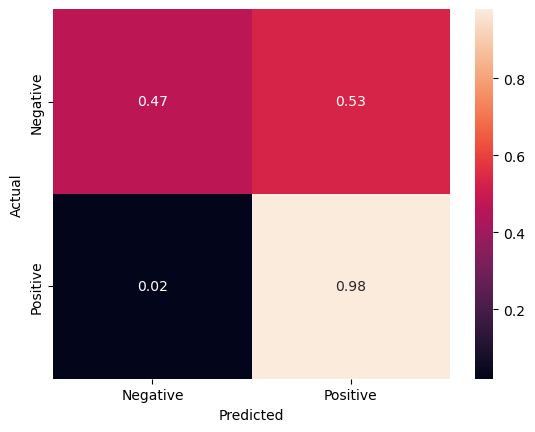

In [75]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### KNN

In [76]:
classifier = KNeighborsClassifier()
classifier.fit(X_train_bow, y_train)

KNeighborsClassifier()

In [77]:
y_test_pred = classifier.predict(X_test_bow)

In [78]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8755868544600939
F1 Score :  0.932051282051282
Classification Report :
              precision    recall  f1-score   support

    Negative       0.67      0.16      0.26       231
    Positive       0.88      0.99      0.93      1473

    accuracy                           0.88      1704
   macro avg       0.77      0.58      0.60      1704
weighted avg       0.85      0.88      0.84      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

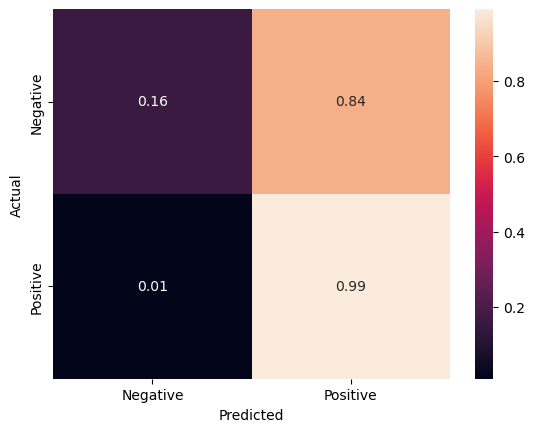

In [79]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### MultinomialNB

In [80]:
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

MultinomialNB()

In [81]:
y_test_pred = classifier.predict(X_test_bow)

In [82]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8990610328638498
F1 Score :  0.9431216931216931
Classification Report :
              precision    recall  f1-score   support

    Negative       0.69      0.46      0.55       231
    Positive       0.92      0.97      0.94      1473

    accuracy                           0.90      1704
   macro avg       0.81      0.71      0.75      1704
weighted avg       0.89      0.90      0.89      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

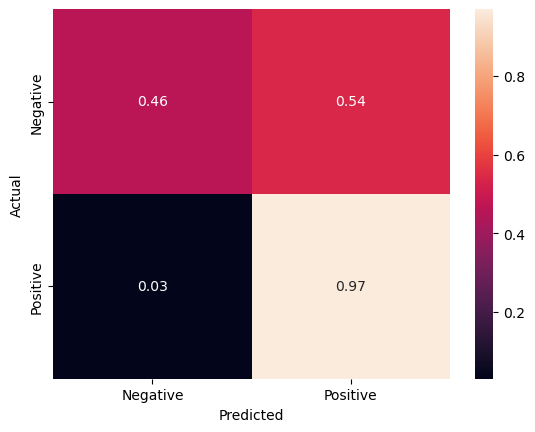

In [83]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### SVM (SVC)

In [84]:
classifier = SVC()
classifier.fit(X_train_bow, y_train)

SVC()

In [85]:
y_test_pred = classifier.predict(X_test_bow)

In [86]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.897887323943662
F1 Score :  0.9434697855750488
Classification Report :
              precision    recall  f1-score   support

    Negative       0.79      0.34      0.47       231
    Positive       0.90      0.99      0.94      1473

    accuracy                           0.90      1704
   macro avg       0.85      0.66      0.71      1704
weighted avg       0.89      0.90      0.88      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

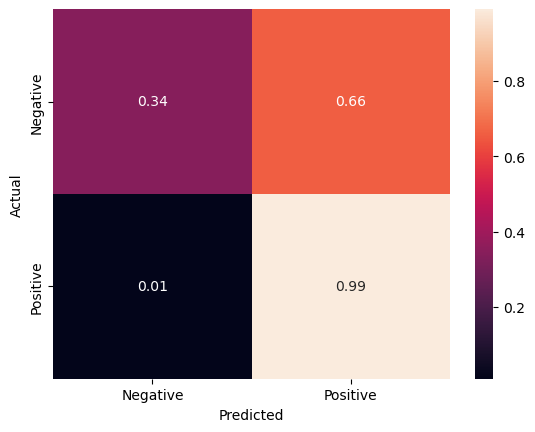

In [87]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [88]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train_bow, y_train)

DecisionTreeClassifier()

In [89]:
y_test_pred = classifier.predict(X_test_bow)

In [90]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8814553990610329
F1 Score :  0.9326217478318879
Classification Report :
              precision    recall  f1-score   support

    Negative       0.58      0.45      0.51       231
    Positive       0.92      0.95      0.93      1473

    accuracy                           0.88      1704
   macro avg       0.75      0.70      0.72      1704
weighted avg       0.87      0.88      0.87      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

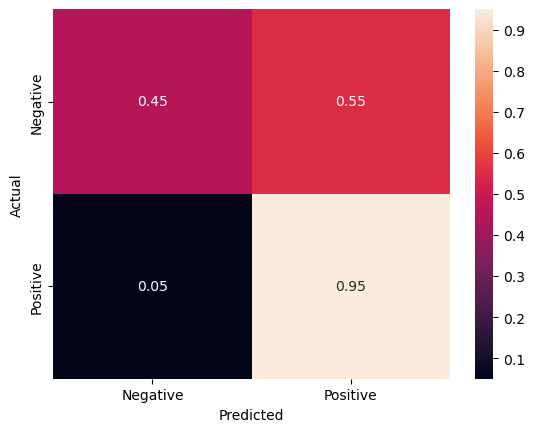

In [91]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Random Forest

In [92]:
classifier = RandomForestClassifier()
classifier.fit(X_train_bow, y_train)

RandomForestClassifier()

In [93]:
y_test_pred = classifier.predict(X_test_bow)

In [94]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.9019953051643192
F1 Score :  0.9451559934318555
Classification Report :
              precision    recall  f1-score   support

    Negative       0.74      0.42      0.54       231
    Positive       0.92      0.98      0.95      1473

    accuracy                           0.90      1704
   macro avg       0.83      0.70      0.74      1704
weighted avg       0.89      0.90      0.89      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

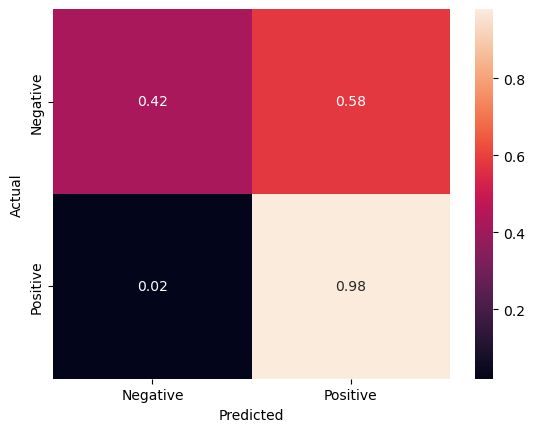

In [95]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Converting Text to Numerical vectors - Word2Vec Representation

In [96]:
X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  
6289                              really nice superread  
549   must buy! slow shuttle. feel like cheated qual...  
4707                         excellent nice productread  
764   yones mavis 350 blue cap wrost duplicate produ...  
6861                               good choice goodread

In [97]:
print(gensim.__version__)

4.1.2


In [98]:
X_train['tokenised_sentences'] = X_train.clean_combine_review_lemma.apply(lambda sent : sent.split())

X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  \
6289                              really nice superread   
549   must buy! slow shuttle. feel like cheated qual...   
4707                         excellent nice productread   
764   yones mavis 350 blue cap wrost duplicate produ...   
6861                               good choice goodread   

                                    tokenised_sentences  
6289                          [really, nice, superread]  
549   [must, buy!, slow, shuttle., feel, like, cheat...  
4707                     [excellent, nice, productread]  
764   [yones, mavis, 350, blue, cap, wrost, duplicat...  
6861                           [good, choice, goodread]

In [99]:
# train model

model = Word2Vec(list(X_train.tokenised_sentences), vector_size=300, min_count=1)

In [100]:
print(model)

Word2Vec(vocab=4688, vector_size=300, alpha=0.025)


In [101]:
# Checking the shape of vectors learned by the model

print(model.wv.__getitem__(model.wv.index_to_key).shape)

(4688, 300)


In [102]:
def document_vector(doc, keyed_vectors):
    """Remove out-of-vocabulary words. Create document vectors by averaging word vectors."""
    vocab_tokens = [word for word in doc if word in keyed_vectors.index_to_key]
    return np.mean(keyed_vectors.__getitem__(vocab_tokens), axis=0)

In [103]:
X_train['doc_vector'] = X_train.tokenised_sentences.progress_apply(lambda x : document_vector(x, model.wv))

100%|████████████████████████████████████████████████████████████████████████████| 6814/6814 [00:00<00:00, 6830.97it/s]


In [104]:
X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  \
6289                              really nice superread   
549   must buy! slow shuttle. feel like cheated qual...   
4707                         excellent nice productread   
764   yones mavis 350 blue cap wrost duplicate produ...   
6861                               good choice goodread   

                                    tokenised_sentences  \
6289                          [really, nice, superread]   
549   [must, buy!, slow, shuttle., feel, like, cheat...   
4707                     [excellent, nice, productread]   
764   [yones, mavis, 350, blue, cap, wrost, duplicat...   
6861                           [good, choice, goodread]   

                                             doc_vector  
6289  [-0.054862034, 0.11341524, 0.0072449404, 0.175...  
549   [-0.062659495, 0.12437875, 0.010170298, 0.1891...  
4707  [-0.058001798, 0.11907143, 0.00886136, 0.18374...  
764   [-0.040563058, 0.08305147, 0.0071512917, 0.128...  
6861  [-0.05484566, 0.11600671, 0.01061168, 0.181105...

In [105]:
X_train_w2v = list(X_train.doc_vector)

In [106]:
X_test.head()

Combine Review  \
7497  Nice product Happy with this productREAD MORE   
5257                 Terrible product GoodREAD MORE   
2571        Terrific purchase As regular 😇READ MORE   
1084                Nice One day 1cap gaanREAD MORE   
856                      Very Good No goodREAD MORE   

           clean_combine_review_lemma  
7497   nice product happy productread  
5257        terrible product goodread  
2571  terrific purchase regular 😇read  
1084       nice one day 1cap gaanread  
856                     good goodread

In [107]:
X_test['tokenised_sentences'] = X_test.clean_combine_review_lemma.apply(lambda sent : sent.split())

X_test.head()

Combine Review  \
7497  Nice product Happy with this productREAD MORE   
5257                 Terrible product GoodREAD MORE   
2571        Terrific purchase As regular 😇READ MORE   
1084                Nice One day 1cap gaanREAD MORE   
856                      Very Good No goodREAD MORE   

           clean_combine_review_lemma                   tokenised_sentences  
7497   nice product happy productread   [nice, product, happy, productread]  
5257        terrible product goodread         [terrible, product, goodread]  
2571  terrific purchase regular 😇read  [terrific, purchase, regular, 😇read]  
1084       nice one day 1cap gaanread      [nice, one, day, 1cap, gaanread]  
856                     good goodread                      [good, goodread]

In [108]:
X_test['doc_vector'] = X_test.tokenised_sentences.progress_apply(lambda x : document_vector(x, model.wv))

100%|████████████████████████████████████████████████████████████████████████████| 1704/1704 [00:00<00:00, 5747.74it/s]


In [109]:
X_test.head()

Combine Review  \
7497  Nice product Happy with this productREAD MORE   
5257                 Terrible product GoodREAD MORE   
2571        Terrific purchase As regular 😇READ MORE   
1084                Nice One day 1cap gaanREAD MORE   
856                      Very Good No goodREAD MORE   

           clean_combine_review_lemma                   tokenised_sentences  \
7497   nice product happy productread   [nice, product, happy, productread]   
5257        terrible product goodread         [terrible, product, goodread]   
2571  terrific purchase regular 😇read  [terrific, purchase, regular, 😇read]   
1084       nice one day 1cap gaanread      [nice, one, day, 1cap, gaanread]   
856                     good goodread                      [good, goodread]   

                                             doc_vector  
7497  [-0.06526527, 0.1318087, 0.010599386, 0.200637...  
5257  [-0.051730562, 0.106335044, 0.008561794, 0.160...  
2571  [-0.06004898, 0.123533644, 0.009687061, 0.1921...  
1084  [-0.11668077, 0.23888981, 0.017435303, 0.37481...  
856   [-0.056114852, 0.117722295, 0.010422174, 0.184...

In [110]:
X_test_w2v = list(X_test.doc_vector)

### Logistic Regression

In [111]:
classifier = LogisticRegression()
classifier.fit(X_train_w2v, y_train)

LogisticRegression()

In [112]:
y_test_pred = classifier.predict(X_test_w2v)

In [113]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8644366197183099
F1 Score :  0.9272898961284229
Classification Report :
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       231
    Positive       0.86      1.00      0.93      1473

    accuracy                           0.86      1704
   macro avg       0.43      0.50      0.46      1704
weighted avg       0.75      0.86      0.80      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

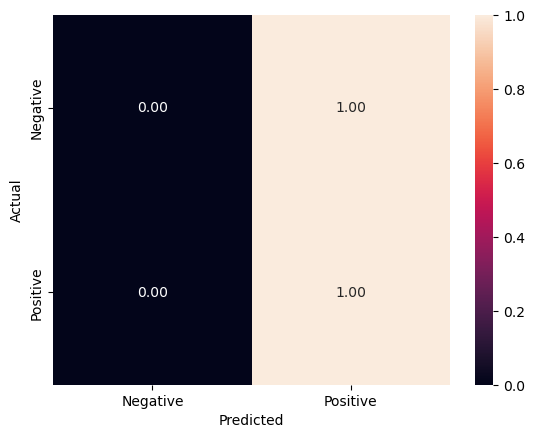

In [114]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### KNN

In [115]:
classifier = KNeighborsClassifier()
classifier.fit(X_train_w2v, y_train)

KNeighborsClassifier()

In [116]:
y_test_pred = classifier.predict(X_test_w2v)

In [117]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8544600938967136
F1 Score :  0.9191655801825294
Classification Report :
              precision    recall  f1-score   support

    Negative       0.42      0.20      0.27       231
    Positive       0.88      0.96      0.92      1473

    accuracy                           0.85      1704
   macro avg       0.65      0.58      0.59      1704
weighted avg       0.82      0.85      0.83      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

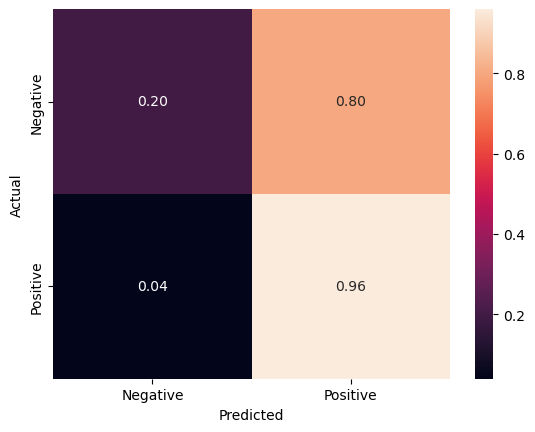

In [118]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [119]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train_w2v, y_train)

DecisionTreeClassifier()

In [120]:
y_test_pred = classifier.predict(X_test_w2v)

In [121]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8092723004694836
F1 Score :  0.8882777586799588
Classification Report :
              precision    recall  f1-score   support

    Negative       0.32      0.38      0.35       231
    Positive       0.90      0.88      0.89      1473

    accuracy                           0.81      1704
   macro avg       0.61      0.63      0.62      1704
weighted avg       0.82      0.81      0.82      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

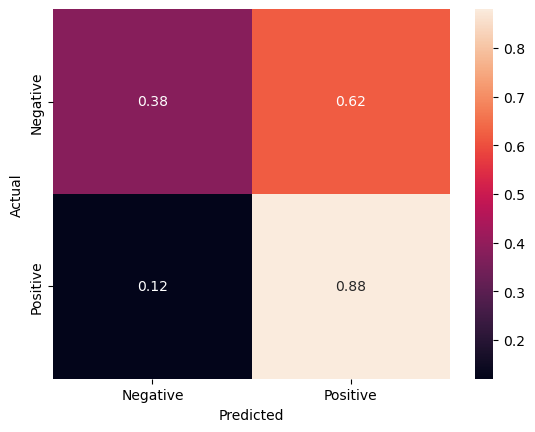

In [122]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Random Forest

In [123]:
classifier = RandomForestClassifier()
classifier.fit(X_train_w2v, y_train)

RandomForestClassifier()

In [124]:
y_test_pred = classifier.predict(X_test_w2v)

In [125]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8732394366197183
F1 Score :  0.9308578745198464
Classification Report :
              precision    recall  f1-score   support

    Negative       0.64      0.15      0.24       231
    Positive       0.88      0.99      0.93      1473

    accuracy                           0.87      1704
   macro avg       0.76      0.57      0.59      1704
weighted avg       0.85      0.87      0.84      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

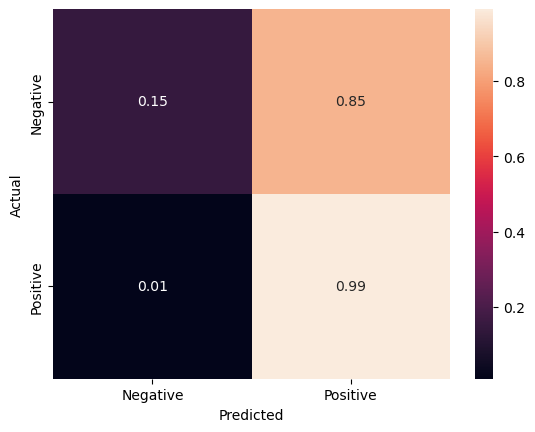

In [126]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Pretrained BERT for Sentence Vector

In [127]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [128]:
X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  \
6289                              really nice superread   
549   must buy! slow shuttle. feel like cheated qual...   
4707                         excellent nice productread   
764   yones mavis 350 blue cap wrost duplicate produ...   
6861                               good choice goodread   

                                    tokenised_sentences  \
6289                          [really, nice, superread]   
549   [must, buy!, slow, shuttle., feel, like, cheat...   
4707                     [excellent, nice, productread]   
764   [yones, mavis, 350, blue, cap, wrost, duplicat...   
6861                           [good, choice, goodread]   

                                             doc_vector  
6289  [-0.054862034, 0.11341524, 0.0072449404, 0.175...  
549   [-0.062659495, 0.12437875, 0.010170298, 0.1891...  
4707  [-0.058001798, 0.11907143, 0.00886136, 0.18374...  
764   [-0.040563058, 0.08305147, 0.0071512917, 0.128...  
6861  [-0.05484566, 0.11600671, 0.01061168, 0.181105...

In [129]:
X_train['doc_vector_pretrained_bert'] = X_train.clean_combine_review_lemma.progress_apply(model.encode)

X_train.head()

100%|██████████████████████████████████████████████████████████████████████████████| 6814/6814 [03:28<00:00, 32.64it/s]


Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  \
6289                              really nice superread   
549   must buy! slow shuttle. feel like cheated qual...   
4707                         excellent nice productread   
764   yones mavis 350 blue cap wrost duplicate produ...   
6861                               good choice goodread   

                                    tokenised_sentences  \
6289                          [really, nice, superread]   
549   [must, buy!, slow, shuttle., feel, like, cheat...   
4707                     [excellent, nice, productread]   
764   [yones, mavis, 350, blue, cap, wrost, duplicat...   
6861                           [good, choice, goodread]   

                                             doc_vector  \
6289  [-0.054862034, 0.11341524, 0.0072449404, 0.175...   
549   [-0.062659495, 0.12437875, 0.010170298, 0.1891...   
4707  [-0.058001798, 0.11907143, 0.00886136, 0.18374...   
764   [-0.040563058, 0.08305147, 0.0071512917, 0.128...   
6861  [-0.05484566, 0.11600671, 0.01061168, 0.181105...   

                             doc_vector_pretrained_bert  
6289  [-0.10135722, -0.06904962, 0.032311574, -0.027...  
549   [-0.0004583775, -0.09589057, 0.059958864, -0.0...  
4707  [-0.096058935, 0.017768094, 0.019963264, -0.00...  
764   [-0.0843163, 0.017256975, 0.04748035, -0.03687...  
6861  [-0.050876167, -0.022384284, 0.029992273, 0.05...

In [130]:
X_train_bert_pretrained = list(X_train.doc_vector_pretrained_bert)

In [131]:
X_test['doc_vector_pretrained_bert'] = X_test.clean_combine_review_lemma.progress_apply(model.encode)

100%|██████████████████████████████████████████████████████████████████████████████| 1704/1704 [00:47<00:00, 35.51it/s]


In [132]:
X_test_bert_pretrained = list(X_test.doc_vector_pretrained_bert)

### Logistic Regression

In [133]:
classifier = LogisticRegression()
classifier.fit(X_train_bert_pretrained, y_train)

LogisticRegression()

In [134]:
y_test_pred = classifier.predict(X_test_bert_pretrained)

In [135]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.9043427230046949
F1 Score :  0.9463992107859257
Classification Report :
              precision    recall  f1-score   support

    Negative       0.75      0.44      0.56       231
    Positive       0.92      0.98      0.95      1473

    accuracy                           0.90      1704
   macro avg       0.83      0.71      0.75      1704
weighted avg       0.89      0.90      0.89      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

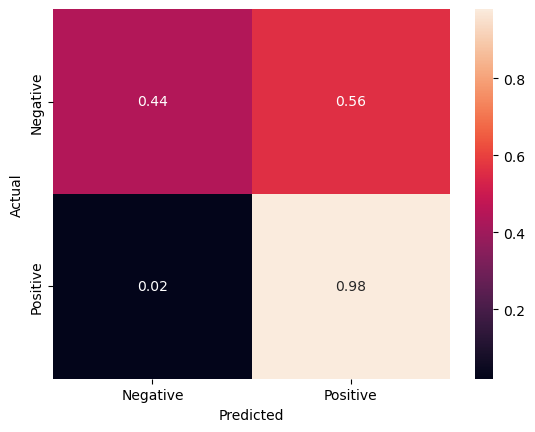

In [136]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### KNN

In [137]:
classifier = KNeighborsClassifier()
classifier.fit(X_train_bert_pretrained, y_train)

KNeighborsClassifier()

In [138]:
y_test_pred = classifier.predict(X_test_bert_pretrained)

In [139]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8937793427230047
F1 Score :  0.9413290113452187
Classification Report :
              precision    recall  f1-score   support

    Negative       0.77      0.31      0.44       231
    Positive       0.90      0.99      0.94      1473

    accuracy                           0.89      1704
   macro avg       0.84      0.65      0.69      1704
weighted avg       0.88      0.89      0.87      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

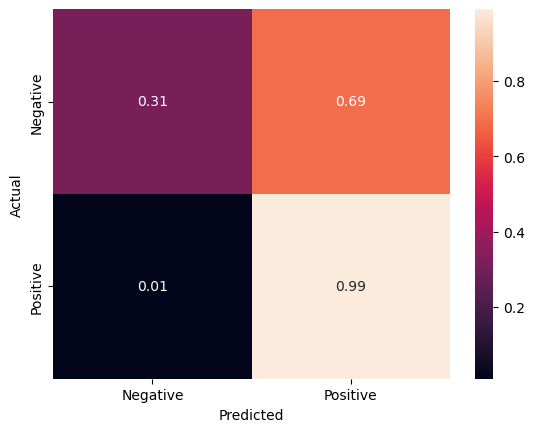

In [140]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision Tree

In [141]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train_bert_pretrained, y_train)

DecisionTreeClassifier()

In [142]:
y_test_pred = classifier.predict(X_test_bert_pretrained)

In [143]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8339201877934272
F1 Score :  0.9037087444709085
Classification Report :
              precision    recall  f1-score   support

    Negative       0.39      0.40      0.40       231
    Positive       0.91      0.90      0.90      1473

    accuracy                           0.83      1704
   macro avg       0.65      0.65      0.65      1704
weighted avg       0.84      0.83      0.83      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

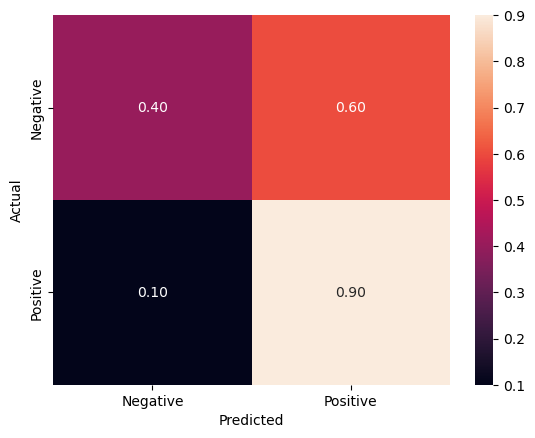

In [144]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Random Forest

In [145]:
classifier = RandomForestClassifier()
classifier.fit(X_train_bert_pretrained, y_train)

RandomForestClassifier()

In [146]:
y_test_pred = classifier.predict(X_test_bert_pretrained)

In [147]:
print('Accuracy Score : ', accuracy_score(y_test, y_test_pred))
print('F1 Score : ', metrics.f1_score(y_test, y_test_pred, pos_label='Positive'))
print('Classification Report :')
print(classification_report(y_test, y_test_pred))

Accuracy Score :  0.8849765258215962
F1 Score :  0.9367333763718528
Classification Report :
              precision    recall  f1-score   support

    Negative       0.72      0.25      0.37       231
    Positive       0.89      0.99      0.94      1473

    accuracy                           0.88      1704
   macro avg       0.81      0.62      0.65      1704
weighted avg       0.87      0.88      0.86      1704



<AxesSubplot:>

Text(50.722222222222214, 0.5, 'Actual')

Text(0.5, 23.52222222222222, 'Predicted')

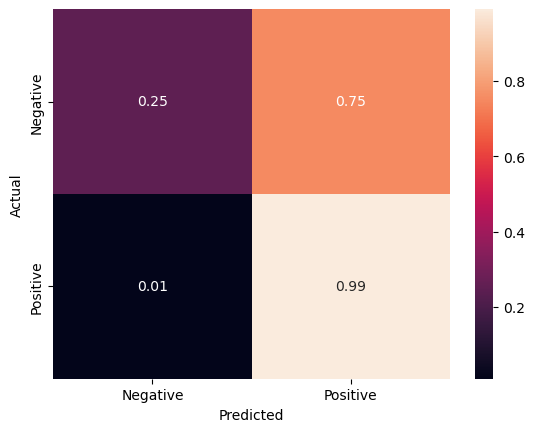

In [148]:
cm = confusion_matrix(y_test, y_test_pred)

actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [149]:
X_train.doc_vector.values[1].shape

(300,)

In [150]:
X_train.doc_vector_pretrained_bert.values[1].shape

(384,)

## Visualization for W2V Embeddings

In [151]:
X_train.head()

Combine Review  \
6289                         Really Nice superREAD MORE   
549   Must buy! Very slow shuttle. Feels like cheate...   
4707                    Excellent Nice productREAD MORE   
764   Yones Mavis 350 Blue cap Wrost and duplicate p...   
6861                          Good choice goodREAD MORE   

                              clean_combine_review_stem  \
6289                              realli nice superread   
549   must buy! slow shuttle. feel like cheat qualit...   
4707                             excel nice productread   
764   yone mavi 350 blue cap wrost duplic productdon...   
6861                                good choic goodread   

                             clean_combine_review_lemma  \
6289                              really nice superread   
549   must buy! slow shuttle. feel like cheated qual...   
4707                         excellent nice productread   
764   yones mavis 350 blue cap wrost duplicate produ...   
6861                               good choice goodread   

                                    tokenised_sentences  \
6289                          [really, nice, superread]   
549   [must, buy!, slow, shuttle., feel, like, cheat...   
4707                     [excellent, nice, productread]   
764   [yones, mavis, 350, blue, cap, wrost, duplicat...   
6861                           [good, choice, goodread]   

                                             doc_vector  \
6289  [-0.054862034, 0.11341524, 0.0072449404, 0.175...   
549   [-0.062659495, 0.12437875, 0.010170298, 0.1891...   
4707  [-0.058001798, 0.11907143, 0.00886136, 0.18374...   
764   [-0.040563058, 0.08305147, 0.0071512917, 0.128...   
6861  [-0.05484566, 0.11600671, 0.01061168, 0.181105...   

                             doc_vector_pretrained_bert  
6289  [-0.10135722, -0.06904962, 0.032311574, -0.027...  
549   [-0.0004583775, -0.09589057, 0.059958864, -0.0...  
4707  [-0.096058935, 0.017768094, 0.019963264, -0.00...  
764   [-0.0843163, 0.017256975, 0.04748035, -0.03687...  
6861  [-0.050876167, -0.022384284, 0.029992273, 0.05...

In [152]:
X_train.columns

Index(['Combine Review', 'clean_combine_review_stem',
       'clean_combine_review_lemma', 'tokenised_sentences', 'doc_vector',
       'doc_vector_pretrained_bert'],
      dtype='object')

In [153]:
w2v_embeddings = np.array(X_train['doc_vector'].tolist())

w2v_embeddings.shape

(6814, 300)

In [154]:
Review_Sentiment = y_train.apply(lambda x : 1 if x=='Positive' else 0)

len(Review_Sentiment)

6814

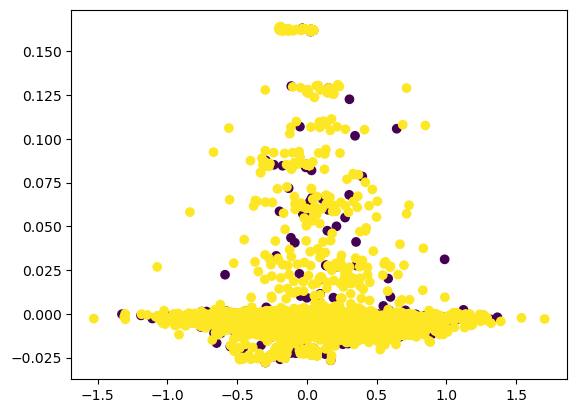

In [155]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(w2v_embeddings)

pca_df = pd.DataFrame(data=pca_data, columns=("Dim_1", "Dim_2"))
pca_df["Review_Sentiment"] = Review_Sentiment

plt.scatter(pca_df['Dim_1'], pca_df['Dim_2'], c=pca_df['Review_Sentiment'])
plt.show()

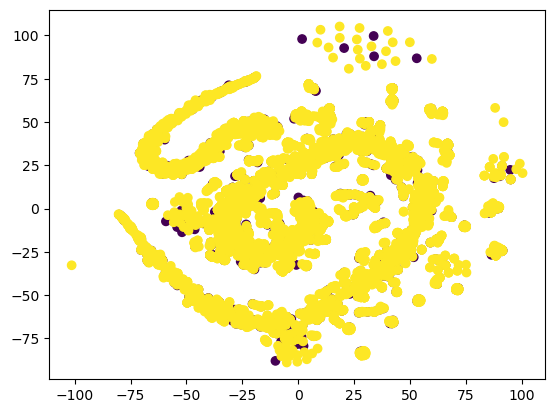

In [156]:
tsne = TSNE(n_components=2, random_state=0, n_iter=1000)

tsne_data = tsne.fit_transform(w2v_embeddings)

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))
tsne_df["Review_Sentiment"] = Review_Sentiment

plt.scatter(tsne_df['Dim_1'], tsne_df['Dim_2'], c=tsne_df['Review_Sentiment'])
plt.show()

## Visualization for Pretrained BERT Embeddings

In [157]:
X_train.columns

Index(['Combine Review', 'clean_combine_review_stem',
       'clean_combine_review_lemma', 'tokenised_sentences', 'doc_vector',
       'doc_vector_pretrained_bert'],
      dtype='object')

In [158]:
pretrained_bert_embeddings = np.array(X_train['doc_vector_pretrained_bert'].tolist())

pretrained_bert_embeddings.shape

(6814, 384)

In [159]:
Review_Sentiment = y_train.apply(lambda x : 1 if x=='Positive' else 0)

len(Review_Sentiment)

6814

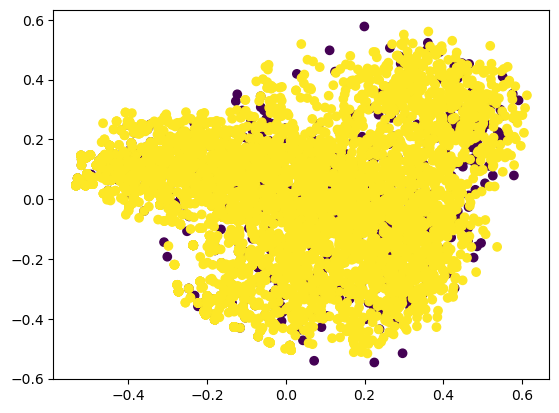

In [160]:
pca = PCA(n_components = 2)
pca_data = pca.fit_transform(pretrained_bert_embeddings)

pca_df = pd.DataFrame(data=pca_data, columns=("Dim_1", "Dim_2"))
pca_df["Review_Sentiment"] = Review_Sentiment

plt.scatter(pca_df['Dim_1'], pca_df['Dim_2'], c=pca_df['Review_Sentiment'])
plt.show()

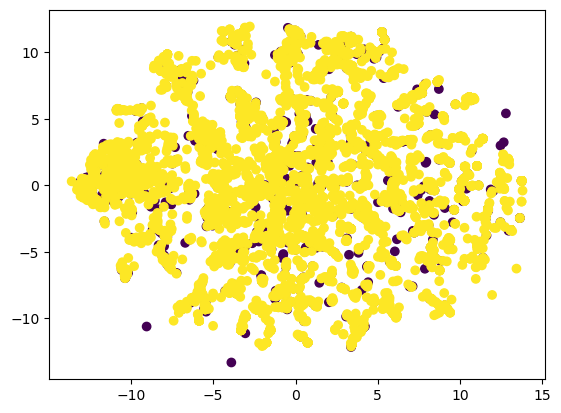

In [161]:
tsne = TSNE(n_components=2, random_state=0, n_iter=300)

tsne_data = tsne.fit_transform(pretrained_bert_embeddings)

tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))
tsne_df["Review_Sentiment"] = Review_Sentiment

plt.scatter(tsne_df['Dim_1'], tsne_df['Dim_2'], c=tsne_df['Review_Sentiment'])
plt.show()